# Part 1: ETL using ProcessGameState python class

In this section we will use the python class ProcessGameState to load in our data, set the boundaries of interest, and

## Load in Dependencies

The python class uses 3 non-standard python libraries pandas, numpy and pyarrow. I will breifly cover the reasons for the use of these packages:

**game_state_frame_data.parquet:** Since our data is store in a .parquet file format, standard python libraries don't support any methods that could read .parquet files. As a result Pandas and Pyarrow are used in order to read in the file into a DataFrame

**numpy:** Since we initially load in our data through Pandas, our data is stored as a DataFrame. The columns of a DataFrame are stored as numpy array; thus, I am using numpy to manipulate these numpy arrays and mantain consistency in data types.

**list vs np.array vs pd.DataFrame:** For a most efficient algorithm it would optimal to use list instead of numpy arrays and dataframes. The article cited below provides a surface level comparison of the performace of each data type. To summarize, lists are faster than numpy array and pandas data frame for small datasets and large static datasets. *However, since our data initializes in the form of data frame and numpy arrays, it would inefficient to convert these arrays to a list form to then run the algorithm.* (As a side note, numpy array and pandas dataframes have good functionality with visualization packages such as matplotlib or seaborn which add to its usefullness)

https://www.benjaminmgross.com/matching-performance-using-python-listss-ndarrays-and-pandas/

In [1]:
'''
dependencies
!pip install pandas
!pip install numpy
!pip install pyarrow
'''

from ProcessGameState import ProcessGameState

## Set file path and XYZ bounds

In [2]:
file = 'data/game_state_frame_data.parquet'

XYbounds = [
    [-1735, 250],
    [-2024, 398],
    [-2806, 742],
    [-2472, 1233],
    [-1565, 580]
]

Zbounds = [285, 421]

## Data Processing

Let's use the create class to load in our data, check player positions according to boundaries, and transform our weapons column for analysis.

In [3]:
Game = ProcessGameState().loadFile(file)
Game = Game.setXYBounds(XYbounds)
Game = Game.setZBounds(Zbounds)
Game = Game.process(bounds=True, weapons=True)
Game = Game.hasRfSMG()

Now we have a DataFrame with 2 new columns *'inBounds'* and *'weapon_classes'* we will use this DataFrame to answer several questions about our data.

**inBounds:** a Boolean that indicates if the player's current position is inside of the set boundary

**weapon_classes:** a list the contains the weapon classes of all weapons in a players inventory (knives are not considered a weapon)

In [4]:
data = Game.data
data.head()

,round_num,tick,side,team,hp,armor,is_alive,x,y,z,...,clock_time,t_alive,ct_alive,bomb_planted,map_name,utility_used,player,inBounds,weapon_classes,hasRfSMG
0,1,2511,T,Team1,100,100,True,-1310,-3333,294,...,01:55,5,5,False,de_overpass,0.0,Player0,False,"[Pistols, Grenade]",False
1,1,2527,T,Team1,100,100,True,-1303,-3322,294,...,01:55,5,5,False,de_overpass,0.0,Player0,False,"[Pistols, Grenade]",False
2,1,2543,T,Team1,100,100,True,-1290,-3303,292,...,01:55,5,5,False,de_overpass,0.0,Player0,False,"[Pistols, Grenade]",False
3,1,2559,T,Team1,100,100,True,-1275,-3280,290,...,01:55,5,5,False,de_overpass,0.0,Player0,False,"[Pistols, Grenade]",False
4,1,2575,T,Team1,100,100,True,-1254,-3262,288,...,01:55,5,5,False,de_overpass,0.0,Player0,False,"[Pistols, Grenade]",False


# Part 2: Game Analysis

Using the processed data from the ProcessGamesState() python class that I've created, we will now answer several questions that can be anwered by our data.

## Question 1: Is entering via the light blue boundary a common strategy used by Team2 on T (terrorist) side?

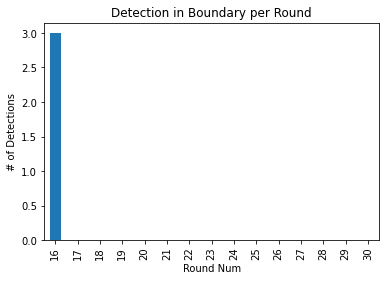

In [5]:
T2_T_data = data[(data['side'] == 'T') & \
                  (data['team'] == 'Team2')]
T2_T_round_data = T2_T_data.groupby('round_num')
ax = T2_T_round_data['inBounds'].sum().plot.bar(xlabel='Round Num',
                                          ylabel='# of Detections',
                                          title = 'Detection in Boundary per Round')

According to this chart we see that out of the 15 rounds Team 2 was on T side, a player on their team was detected to have been in the boundary 1 out of 15 rounds. **As a result, we can say that the light blue boundary is not a common strategy used by Team 2 on T side.**

## Question 2: What is the average timer that Team2 on T (terrorist) side enters “BombsiteB” with least 2 rifles or SMGs?

In [114]:
data_2 = T2_T_data[['round_num', 'side', 'team', 'area_name', 
                    'player', 'clock_time', 'weapon_classes', 'hasRfSMG']]
data_2 = data_2[(data_2['hasRfSMG'] == True) & (data_2['area_name'] == 'BombsiteB')]
grouped_data_2 = data_2.groupby(['round_num', 'player'])
grouped_data_2 = grouped_data_2.first()
grouped_data_2

side   team  area_name clock_time  \
round_num player                                      
21        Player5    T  Team2  BombsiteB      01:35   
          Player8    T  Team2  BombsiteB      01:37   
25        Player5    T  Team2  BombsiteB      01:25   
26        Player5    T  Team2  BombsiteB      00:13   
28        Player5    T  Team2  BombsiteB      01:23   
          Player6    T  Team2  BombsiteB      01:27   
          Player7    T  Team2  BombsiteB      01:22   
          Player8    T  Team2  BombsiteB      01:26   
          Player9    T  Team2  BombsiteB      01:16   
30        Player5    T  Team2  BombsiteB      01:17   
          Player7    T  Team2  BombsiteB      01:14   
          Player8    T  Team2  BombsiteB      01:20   

                              weapon_classes  hasRfSMG  
round_num player                                        
21        Player5           [Pistols, Rifle]      True  
          Player8  [Rifle, Pistols, Grenade]      True  
25        Player5           [Rifle, Pistols]      True  
26        Player5           [Pistols, Rifle]      True  
28        Player5           [Pistols, Rifle]      True  
          Player6  [Pistols, Rifle, Grenade]      True  
          Player7  [Pistols, Rifle, Grenade]      True  
          Player8           [Pistols, Rifle]      True  
          Player9  [Rifle, Grenade, Pistols]      True  
30        Player5           [Pistols, Rifle]      True  
          Player7  [Grenade, Pistols, Rifle]      True  
          Player8           [Pistols, Rifle]      True

From this table we see that only for rounds 21, 28, and 30 where at least 2 players entered BombsiteB with either a Rifle or an SMG. Let's perform an aggregation to find the average clock time of these 3 rounds.

In [152]:
grouped_data_2a = grouped_data_2.reset_index()
grouped_data_2a = grouped_data_2a.groupby('round_num').filter(lambda x : x['hasRfSMG'].count() >=2)
times = list(grouped_data_2a.groupby('round_num')['clock_time'].last())
seconds = []
for time in times:
    m, s = time.split(':')
    seconds.append(int(m) * 60 + int(s))
time = sum(seconds)/len(seconds)
print('Average Clock Time: ', int(time//60), ':', int(time - (time//60) * 60), sep='')
      

Average Clock Time: 1:24


## Question 3: Now that we’ve gathered data on Team2 T side, let's examine their CT (counter-terrorist) Side. Using the same data set, tell our coaching staff where you suspect them to be waiting inside “BombsiteB”

In [174]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

In [161]:
data_3 = Game.data
data_3 = data_3[['x', 'y','round_num', 'side', 'team', 'ct_alive', 'area_name']]
data_3 = data_3[(data_3['area_name'] == 'BombsiteB') & \
                (data_3['team'] == 'Team2') & \
                (data_3['side'] == 'CT')]
data_3

,x,y,round_num,side,team,ct_alive,area_name
67137,-1142,311,2,CT,Team2,5,BombsiteB
67138,-1111,310,2,CT,Team2,5,BombsiteB
67139,-1081,308,2,CT,Team2,5,BombsiteB
67140,-1050,307,2,CT,Team2,5,BombsiteB
67141,-1027,295,2,CT,Team2,5,BombsiteB
...,...,...,...,...,...,...,...
208375,-939,-193,13,CT,Team2,5,BombsiteB
208376,-922,-217,13,CT,Team2,5,BombsiteB
208377,-908,-241,13,CT,Team2,5,BombsiteB
208378,-891,-263,13,CT,Team2,5,BombsiteB


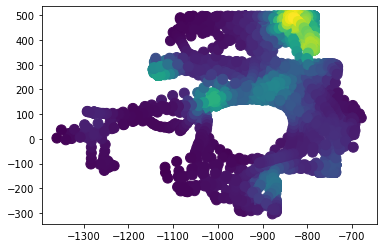

In [181]:
x = data_3['x']
y = data_3['y']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

According to the density map you can expect to see Team 2 to be waiting in the back of Bombsite B and around on the bomb plant area

## Question 3: Most of the time, our stakeholders (in this case, the CS:GO coaching staff) aren’t tech-savvy enough to run code themselves. Propose a solution to your product manager that: 
### a. could allow our coaching staff to request or acquire the output themselves
### b. takes less than 1 weeks worth of work to implement

Since most CS:GO coaches would not be able to run this python class on their own to receive the data, it would be best and fastest for them to receive the data if this python class was a web application. This would make processing the data and receiving insights quick and seamless as they would not have to ask me to load in the data for them.

In order to build the web application, the python class must be given a simple gui. Tkinter can be used to build GUIs in Python so that the user can access the function through a user interface. A good work flow for the user would be:
1. Upload their parquet file from their local machine
2. A visualization of the map will be diplayed based off their file
3. Set the boundaries using an interactive interface that allows them to click on the map and create a shape which will serve as the input to for the process method
4. Sliders and filters that would allow a coach to filter out certain type of data that they want. (Team, Side, Area, Weapons, Rounds, etc.)
5. After setting bonudaries and filter, a button to process the data based off of these parameters that they've set.

In order for this to be implemented, the python class must be altered to take in a variety of parameters so it can run its methods on a variety of parameters, rather than the predesignated functions that were create for the purpose of this assessment.

After the python GUI is built then we can use a web frame work to help build the web application. Django is a high-level python web framework that can aid in this. There are also templates that can help speed up the process so the project can be finished within time.

After the application is built for the web, it can be hosted online through Github pages so that the coach can access the application through a simple link.